La ecuación de Mathieu es de la forma

$$\displaystyle \frac{d^2 \chi_k}{dT^2} + \left[ A_k - 2q \cos(2T) \right] \chi_k = 0$$

Para resolver esta ecuación podemos definir las variables $\displaystyle v = \frac{d\chi_k}{dt}$ y $u = \chi_k$ tal que la ecuación de Mathieu se escribe como el siguiente sistema de ecuaciones:

$$\displaystyle \begin{cases}
    \displaystyle u^\prime = v\\
    \displaystyle v^\prime = - \left[ A_k - 2 q \cos(2T) \right] u
\end{cases}$$

Y para resolver estas ecuaciones usemos un método de Runge Kutta 4, lo cual está dada por

$$\displaystyle y_{n + 1} = y_{n} + \frac{1}{6} \left( K_1 + 2 K_2 + 2 K_3 + K_4 \right)$$

dónde, tenemos $\displaystyle K_1 = h \ f(x_n, y_n)$, $\displaystyle K_2 = h \ f \left( x_n + \frac{h}{2}, y_n + \frac{1}{2} K_1 \right)$, $\displaystyle K_3 = h \ f \left( x_n + \frac{h}{2}, y_n + \frac{K_2}{2} \right)$ y $\displaystyle K_4 = h \ f \left( x_n + h, y_n + K_3 \right)$.

In [1]:
# Importemos las librerías necesarias
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.integrate import solve_ivp

mpl.rc('figure', figsize=(12, 6))
mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif')
mpl.rc('font', size = '14')
mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=14)


In [2]:
# Definamos las funciones necesarias
def mathieu(u, v, T, A_k, q):
    du_dt = v
    dv_dt = - (A_k - 2 * q * np.cos(2 * T)) * u
    return du_dt, dv_dt
def RK4(u0, v0, T0, Tf, dt, A_k, q):
    N = int((Tf - T0) / dt)
    u = np.zeros(N); v = np.zeros(N); T = np.zeros(N)
    u[0] = u0; v[0] = v0; T[0] = T0

    for i in range(1, N):
        k1_u, k1_v = mathieu(u[i-1], v[i-1], T[i-1], A_k, q)
        k2_u, k2_v = mathieu(u[i-1] + 0.5 * dt * k1_u, v[i-1] + 0.5 * dt * k1_v, T[i-1] + 0.5 * dt, A_k, q)
        k3_u, k3_v = mathieu(u[i-1] + 0.5 * dt * k2_u, v[i-1] + 0.5 * dt * k2_v, T[i-1] + 0.5 * dt, A_k, q)
        k4_u, k4_v = mathieu(u[i-1] + dt * k3_u, v[i-1] + dt * k3_v, T[i-1] + dt, A_k, q)
        
        u[i] = u[i-1] + (dt / 6) * (k1_u + 2*k2_u + 2*k3_u + k4_u)
        v[i] = v[i-1] + (dt / 6) * (k1_v + 2*k2_v + 2*k3_v + k4_v)
        T[i] = T[i-1] + dt
    return u, v, T

# Ejemplos de resonancias

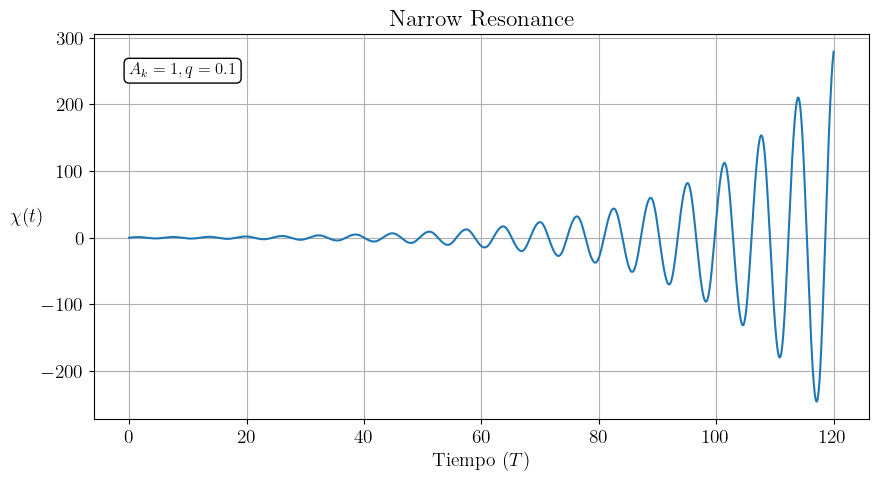

In [3]:
"Narrow resonance"

Ak, q = 1, 0.1        # Parámetros
u0, v0 = 0, 1          # Condiciones iniciales
T0, Tf = 0, 120        # Tiempos
dt = 0.01              # Paso de tiempo

u, v, T = RK4(u0, v0, T0, Tf, dt, Ak, q)

# Graficamos los resultados
plt.figure(figsize=(10, 5))
plt.plot(T, u)
plt.title('Narrow Resonance')
plt.xlabel(r'Tiempo ($T$)')
plt.ylabel(r'$\chi(t)$', labelpad=10, rotation='horizontal')
ymin, ymax = plt.gca().get_ylim()
plt.text(x=T[0], y=ymax*0.8, s=rf'$A_k = {Ak}, q = {q}$', fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
plt.grid()
plt.show()

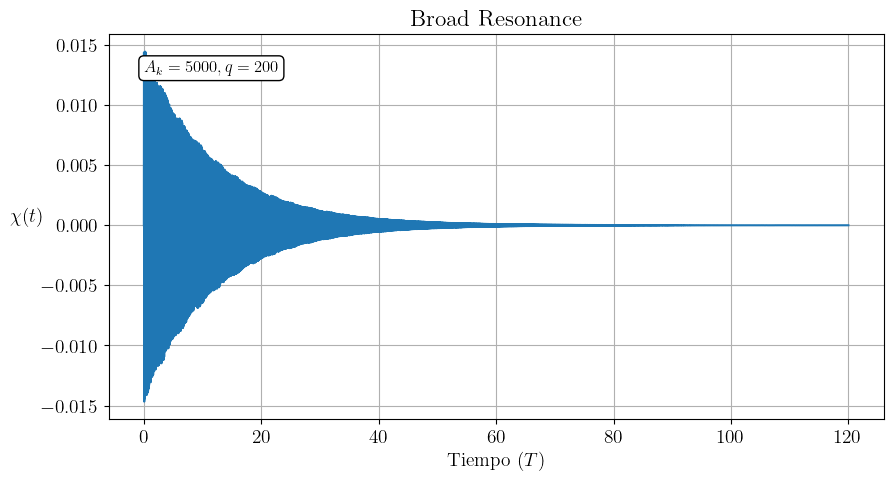

In [5]:
"Broad resonance"

Ak, q = 5000, 200           # Parámetros
u0, v0 = 0, 1               # Condiciones iniciales
T0, Tf = 0, 120             # Tiempos
dt = 0.01                   # Paso de tiempo

u, v, T = RK4(u0, v0, T0, Tf, dt, Ak, q)

# Graficamos los resultados
plt.figure(figsize=(10, 5))
plt.plot(T, u)
plt.title('Broad Resonance')
plt.xlabel(r'Tiempo ($T$)')
plt.ylabel(r'$\chi(t)$', labelpad=10, rotation='horizontal')
ymin, ymax = plt.gca().get_ylim()
plt.text(x=T[0], y=ymax*0.8, s=rf'$A_k = {Ak}, q = {q}$', fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
plt.grid()
plt.show()

# Cálculo de los coeficientes de Floquet

In [6]:
def mathieu_ivp(t, y, A_k, q):
    u, v = y
    du_dt = v
    dv_dt = - (A_k - 2 * q * np.cos(2 * t)) * u
    return [du_dt, dv_dt]

def floquet_coeff(A, q):
    T = np.pi
    sol1 = solve_ivp(mathieu_ivp, [0, T], [1, 0], args=(A, q), rtol=1e-8, atol=1e-8)
    y1_pi, y1_prime_pi = sol1.y[0][-1], sol1.y[1][-1]

    sol2 = solve_ivp(mathieu_ivp, [0, T], [0, 1], args=(A, q), rtol=1e-8, atol=1e-8)
    y2_pi, y2_prime_pi = sol2.y[0][-1], sol2.y[1][-1]

    M = np.array([[y1_pi, y2_pi], [y1_prime_pi, y2_prime_pi]])
    Delta = np.trace(M)

    if abs(Delta) > 2:
        mu_real = np.arccosh(abs(Delta)/2) / T
    else:
        mu_real = 0
    return mu_real

In [6]:
qs = np.linspace(0, 5, 200)
Aks = np.linspace(0, 15, 200)
q, Ak = np.meshgrid(qs, Aks)
mu = np.zeros((len(Aks), len(qs)))

for i in range(len(Aks)):
    for j in range(len(qs)):
        mu[i, j] = floquet_coeff(Aks[i], qs[j])

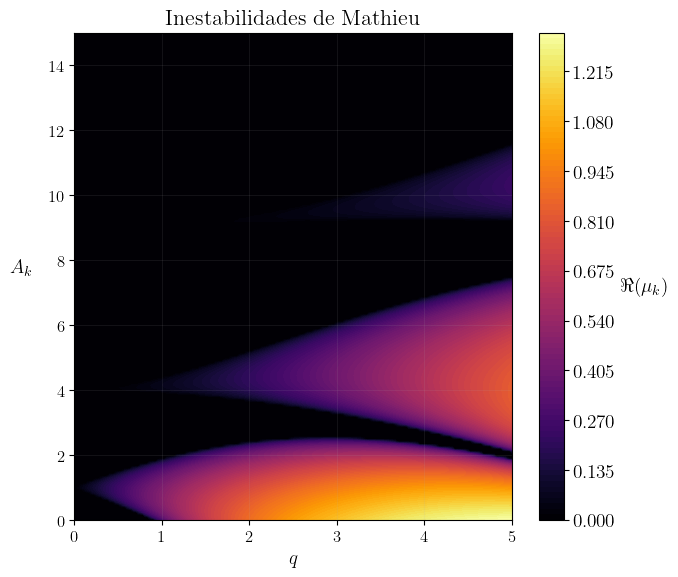

In [7]:
plt.figure(figsize=(7, 6))
contour = plt.contourf(q, Ak, mu, levels=100, cmap='inferno')
cbar = plt.colorbar(contour)
cbar.set_label(r'$\Re(\mu_k)$', fontsize=14, labelpad=20, rotation=0)

plt.title(r'Inestabilidades de Mathieu', fontsize=16)
plt.xlabel(r'$q$', fontsize=14)
plt.ylabel(r'$A_k$', fontsize=14, labelpad=20, rotation=0)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(alpha = 0.1)
plt.tight_layout()
plt.show()

In [8]:
qs = np.linspace(0, 200, 200)
Aks = np.linspace(0, 100, 200)
q, Ak = np.meshgrid(qs, Aks)
mu = np.zeros((len(Aks), len(qs)))

for i in range(len(Aks)):
    for j in range(len(qs)):
        mu[i, j] = floquet_coeff(Aks[i], qs[j])

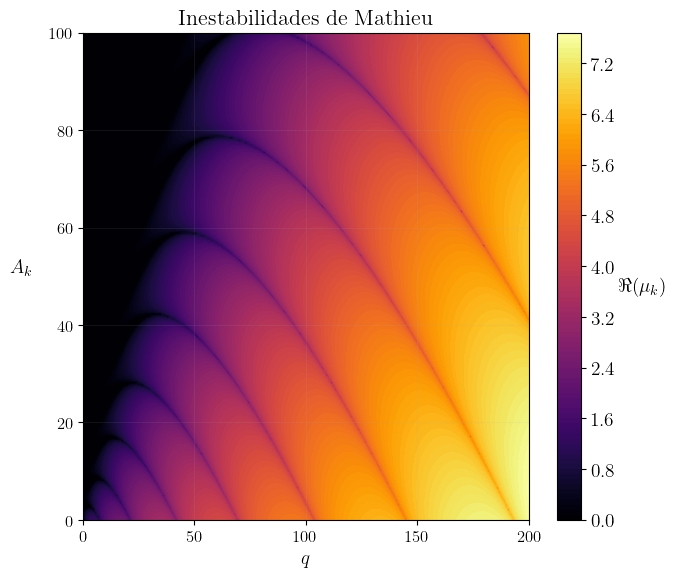

In [9]:
plt.figure(figsize=(7, 6))
contour = plt.contourf(q, Ak, mu, levels=100, cmap='inferno')
cbar = plt.colorbar(contour)
cbar.set_label(r'$\Re(\mu_k)$', fontsize=14, labelpad=20, rotation=0)

plt.title(r'Inestabilidades de Mathieu', fontsize=16)
plt.xlabel(r'$q$', fontsize=14)
plt.ylabel(r'$A_k$', fontsize=14, labelpad=20, rotation=0)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(alpha = 0.1)
plt.tight_layout()
plt.show()

In [ ]:
# Guardemos la información en un CSV
output = np.zeros((len(Aks)+1, len(qs)+1))          # Creamos la matriz que guardará los datos
output[0, 1:] = qs                                  # Encabezado de columnas: q
output[1:, 0] = Aks                                 # Encabezado de filas: Ak
output[1:, 1:] = mu                                 # Datos: mu

np.savetxt("mathieu(A0100-q0200).csv", output, delimiter=",")

# Prueba con las cosas de la IA

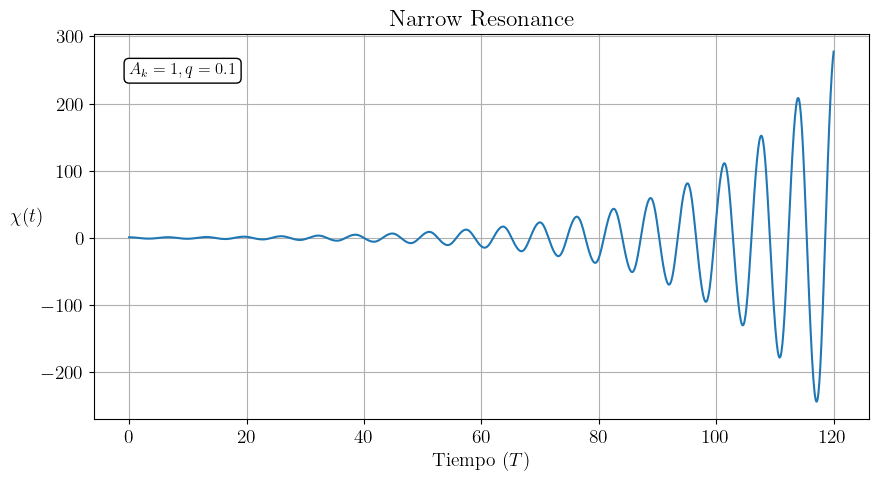

In [14]:
"Narrow resonance"

Ak, q = 1, 0.1              # Parámetros
u0, v0 = 1, 0               # Condiciones iniciales
T0, Tf = 0, 120             # Tiempos
dt = 0.01                   # Paso de tiempo

sol = solve_ivp(mathieu_ivp, [T0, Tf], [u0, v0], args=(Ak, q), rtol=1e-8, atol=1e-8)
t, y, y_prime = sol.t, sol.y[0], sol.y[1]

# Graficamos los resultados
plt.figure(figsize=(10, 5))
plt.plot(t, y)
plt.title('Narrow Resonance')
plt.xlabel(r'Tiempo ($T$)')
plt.ylabel(r'$\chi(t)$', labelpad=10, rotation='horizontal')
ymin, ymax = plt.gca().get_ylim()
plt.text(x=T[0], y=ymax*0.8, s=rf'$A_k = {Ak}, q = {q}$', fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
plt.grid()
plt.show()

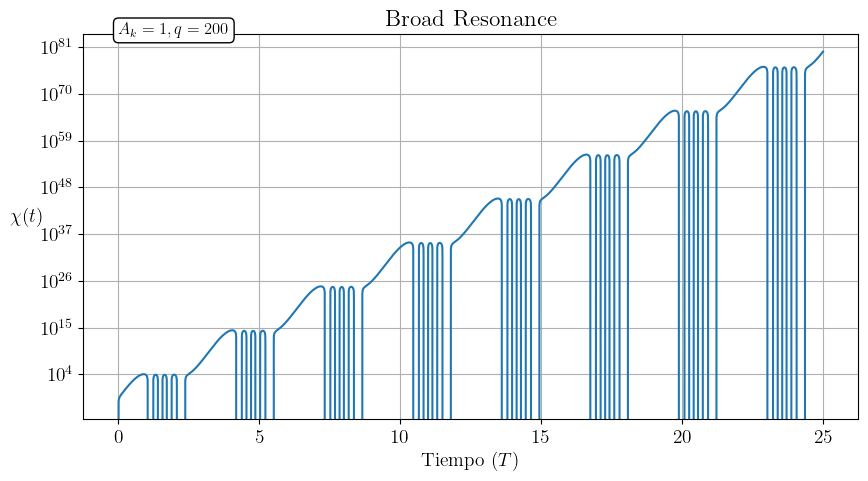

In [27]:
"Broad resonance"

Ak, q = 1, 200              # Parámetros
u0, v0 = 0, 1               # Condiciones iniciales
T0, Tf = 0, 25              # Tiempos
dt = 0.01                   # Paso de tiempo

sol = solve_ivp(mathieu_ivp, [T0, Tf], [u0, v0], args=(Ak, q), rtol=1e-8, atol=1e-8)
t, y, y_prime = sol.t, sol.y[0], sol.y[1]

# Graficamos los resultados
plt.figure(figsize=(10, 5))
plt.plot(t, y)
plt.title('Broad Resonance')
plt.xlabel(r'Tiempo ($T$)')
plt.ylabel(r'$\chi(t)$', labelpad=10, rotation='horizontal')
plt.yscale('log')
ymin, ymax = plt.gca().get_ylim()
plt.text(x=T[0], y=ymax*0.8, s=rf'$A_k = {Ak}, q = {q}$', fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
plt.grid()
plt.show()